In [1]:
import sys
sys.path.append('../../')

import numpy as np
from qiskit import IBMQ, Aer, QuantumCircuit
import matplotlib.pyplot as plt
from main import device_process_measurement_tomography, Quantities, Cross_Quantities, measurement_process_tomography, tomographic_gate_set_tomography
from qiskit.compiler import transpile
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.providers.aer.noise import NoiseModel
from utils_plots import *
from utils_qiskit import *
from joblib import Parallel, delayed

In [2]:
IBMQ.load_account()
# provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
provider = IBMQ.get_provider(hub='ibm-q-research-2', group='csic-1', project='main')

In [3]:
backend = provider.get_backend('ibm_perth')
simulator = Aer.get_backend('aer_simulator')
noise_model = NoiseModel.from_backend(backend)

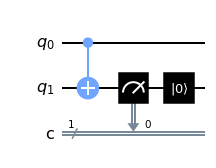

In [4]:
qc = QuantumCircuit(2,1)
qc.cx(0,1)
qc.measure(1,0)
qc.reset(1)
qc.draw(output='mpl')

In [5]:
gst = tomographic_gate_set_tomography( 1 )
mpt = measurement_process_tomography( 1, 1, 1 ) 
qcs = mpt.circuits( qc )
qcs0 = gst.circuits()

In [6]:
jobs_id = [
            '632b994ad95c8ef7bd62c877',
            '632b994ce150f16a8f9e0aee',
            '632b994e6b619a56910d6b03',
            '632b994f6b619aca230d6b04',
            '632b9951e150f173079e0aef']

results = []
for job_id in jobs_id:
    # job = backend.retrieve_job(job_id)
    # results_job = job.result()
    # save_results( results_job, name=job_id, folder='data')

    with open('data/{}.json'.format(job_id), 'r') as f:
        results_job = dict2results( json.load(f) )
 
    results.append( results_job )


In [9]:
mc = 1000

def function(j):
    results_gst = gst.fit( results[j], resampling = 2**13 )
    gate_set    = [results_gst.states, results_gst.measurements, results_gst.processes ] 
    results_mpt = mpt.fit( results[j], gate_set= gst.gateset2spam(gate_set), resampling = 2**13 )
    quantities  = Quantities( results_mpt.povms[0], results_mpt.chois[0] )

    return [ results_mpt.chois[0] , results_mpt.povms[0], quantities ]

In [10]:
results_mc = Parallel( n_jobs=-1 )( delayed(function)(j) for j in range(5) for _ in range(mc) )
np.save( 'data/data_mc_{}'.format(mc), np.array(results_mc, dtype=object) )